In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# Import libraries
from notebook_utils import NotebookUtilities
from os import path as osp
from skimage import io
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, re
import pandas as pd
import requests
import webcolors

nu = NotebookUtilities(data_folder_path=osp.abspath('../data'), saves_folder_path=osp.abspath('../saves'))

In [3]:

def get_original_image(file_path):
    
    # Read the image
    img_array = io.imread(file_path)[:, :, :3]

    return img_array

In [4]:

def get_top_colors(img_array, n_colors, verbose=False):
    
    # Get the palette color which occurs most frequently
    pixels = np.float32(img_array.reshape(-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    if verbose: print(f'palette: {palette}')
    _, counts = np.unique(labels, return_counts=True)

    return labels, palette, counts

In [5]:

def get_indices_and_rows(counts, img_array):
    
    # Create a palette with the most representative colors
    indices = np.argsort(counts)[::-1]
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    height = img_array.shape[0]
    rows = np.int_(height*freqs)

    return indices, rows

In [6]:

if nu.pickle_exists('xkcd_colors'): xkcd_colors = nu.load_object('xkcd_colors')
else:
    file_path = osp.join(nu.saves_text_folder, 'xkcd_colors.txt')
    df = pd.read_csv(file_path, sep='\t', names=['xkcd_name', 'hex_code', 'delete_me'], skiprows=[0]).dropna(axis='columns', how='all')
    def get_rgb_array(hex_code):
        rgb_obj = webcolors.hex_to_rgb(hex_code)
    
        return np.array([rgb_obj.red, rgb_obj.green, rgb_obj.blue, 0.0])
        
    df['xkcd_rgb'] = df.hex_code.map(get_rgb_array)
    xkcd_colors = df.set_index('xkcd_name', drop=True).xkcd_rgb.to_dict()
    nu.store_objects(xkcd_colors=xkcd_colors)

In [7]:

color_distance = lambda rgb, xkcd_color: euclidean_distances(np.array([rgb[:3]]), np.array([xkcd_color[:3]]))[0][0]

In [8]:

def get_nearest_xkcd_color(rgb_array, verbose=False):
    min_distance = float('inf')
    nearest_color = None
    for xkcd_name, xkcd_rgb in xkcd_colors.items():
        distance = color_distance(rgb_array, xkcd_rgb)
        if distance < min_distance:
            min_distance = distance
            nearest_color = xkcd_name
    if verbose: print(f'Nearest xkcd color: {nearest_color}')

    return nearest_color

In [9]:

def get_palette_patch(counts, img_array, palette, verbose=False):
    
    # Create a palette with the most representative colors
    indices, rows = get_indices_and_rows(counts, img_array)
    palette_patch = np.zeros(shape=img_array.shape, dtype=np.uint8)
    for i in range(len(rows) - 1):
        target_color = np.uint8(palette[indices[i]])
        palette_patch[rows[i]:rows[i + 1], :, :] += target_color
        if verbose: print(target_color, get_nearest_xkcd_color(target_color))
    
    return palette_patch

In [10]:

def get_posterized_image(img_array, n_colors=5, labels=None, palette=None, verbose=False):
    
    # Reduce colors to top 5 most frequent
    if labels is None or palette is None:
        labels, palette, _ = get_top_colors(img_array, n_colors, verbose=verbose)
    
    # Replace pixel values with their corresponding palette colors
    posterized_img = palette[labels.flatten()].reshape(img_array.shape)
    
    return posterized_img

In [11]:

def get_gray_image(file_path):
    gray_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    return gray_image

In [12]:

def get_edge_image(gray_image):
    
    # Calculate the median of the pixel intensities
    median_val = np.median(gray_image)
    
    # Set the lower and upper thresholds based on the median
    lower = int(max(0, 0.7 * median_val))
    upper = int(min(255, 1.3 * median_val))
    
    # Apply Canny edge detection
    edge_image = cv2.Canny(image=gray_image, threshold1=lower, threshold2=upper)
    
    return edge_image

In [13]:

def show_images(file_name, img_array, palette_patch, posterized_img, edge_img):
    fig, (original_ax, palette_ax, posterized_ax, edge_ax) = plt.subplots(1, 4, figsize=(12, 6))

    # Show original image
    original_ax.imshow(img_array)
    original_ax.set_title('Original Image')
    original_ax.axis('off')

    # Show color palette
    palette_ax.imshow(palette_patch)
    palette_ax.set_title('Color palette')
    palette_ax.axis('off')

    # Show posterized image
    posterized_ax.imshow(posterized_img.astype(np.uint8))
    posterized_ax.set_title('Posterized Image')
    posterized_ax.axis('off')

    # Show edge image
    edge_ax.imshow(edge_img)
    edge_ax.set_title('Edge Image')
    edge_ax.axis('off')
    
    # Add image title
    plt.suptitle(file_name.split('.')[0].replace('_', ' ').title(), y=0.76)
    # fig.subplots_adjust(top=1.7)
    # fig.tight_layout(h_pad=30.0)
    
    plt.show(fig)

In [14]:

def convert_patches_to_images(file_path, n_colors=5, verbose=False):
    
    # Read the image
    original_image = get_original_image(file_path)
    if verbose: print(f'original_image.shape: {original_image.shape}')
    
    # Create a palette with the n_colors most frequent colors
    labels, palette, counts = get_top_colors(original_image, n_colors, verbose=verbose)
    palette_patch = get_palette_patch(counts, original_image, palette, verbose=verbose)
    
    # Create a posterized image
    posterized_image = get_posterized_image(original_image, n_colors, labels=labels, palette=palette, verbose=verbose)

    # Create an edge image
    gray_image = get_gray_image(file_path)
    edge_image = get_edge_image(gray_image)
    
    show_images(osp.basename(file_path), original_image, palette_patch, posterized_image, edge_image)


# What XKCD Colors are the Top 5 Colors in Your PNG?

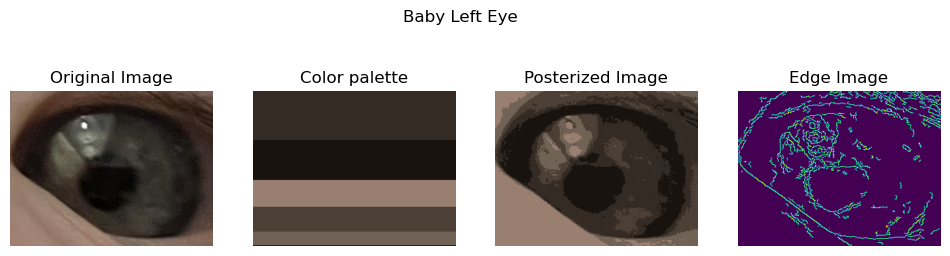

In [15]:

file_path = '../saves/png/baby_left_eye.png'
convert_patches_to_images(file_path, n_colors=5, verbose=False)

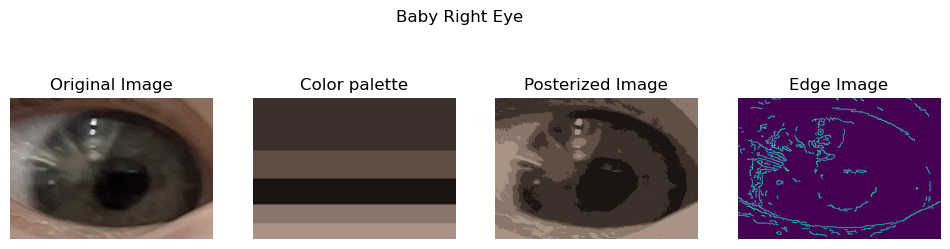

In [16]:

file_path = '../saves/png/baby_right_eye.png'
convert_patches_to_images(file_path, n_colors=5, verbose=False)

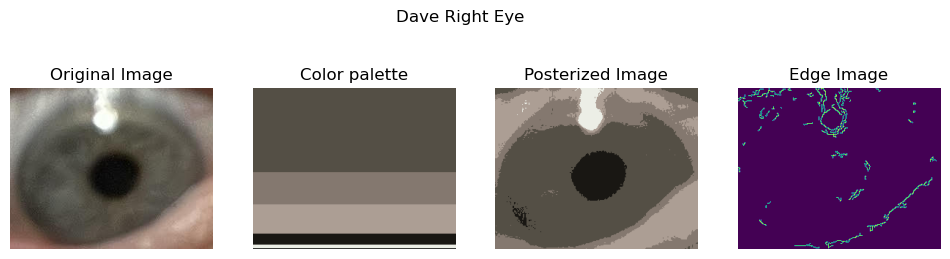

In [17]:

file_path = '../saves/png/dave_right_eye.png'
convert_patches_to_images(file_path, n_colors=5, verbose=False)

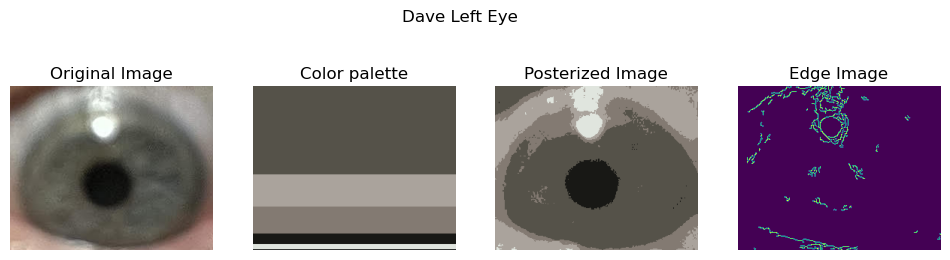

In [18]:

file_path = '../saves/png/dave_left_eye.png'
convert_patches_to_images(file_path, n_colors=5, verbose=False)

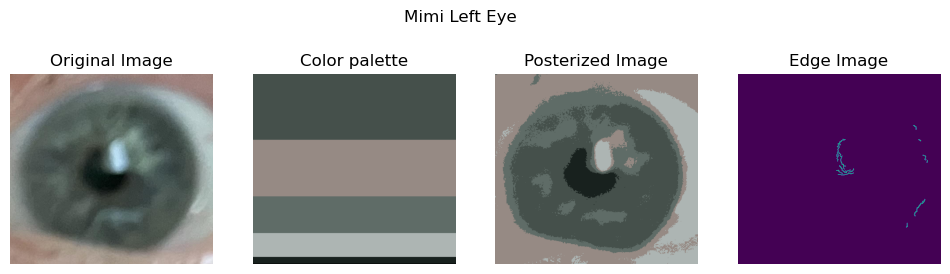

In [19]:

file_path = '../saves/png/mimi_left_eye.png'
convert_patches_to_images(file_path, n_colors=5, verbose=False)

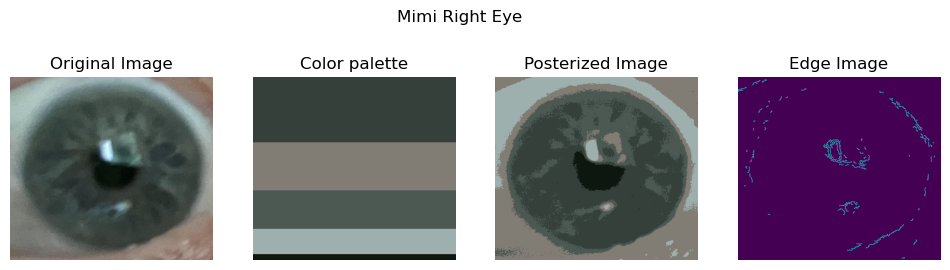

In [20]:

file_path = '../saves/png/mimi_right_eye.png'
convert_patches_to_images(file_path, n_colors=5, verbose=False)

In [21]:

def get_nearest_pixel(target_color, img_array, verbose=False):
    min_distance = float('inf')
    nearest_rgb_array = None
    height = img_array.shape[0]
    for i in range(height):
        for j in range(img_array.shape[1]):  # Loop over the width
            
            # Access the RGB values for the pixel at position (i, j)
            rgb_array = img_array[i, j]
            
            distance = color_distance(rgb_array, target_color)
            if distance < min_distance:
                min_distance = distance
                nearest_rgb_array = rgb_array
    if verbose: print(f'Nearest rgb_array: {nearest_rgb_array}')

    return nearest_rgb_array

In [27]:

def get_largest_blob(labels, points, verbose=False):
    
    # Find the largest blob
    unique_labels = set(labels)
    largest_blob_label = max(unique_labels, key=list(labels).count)
    largest_blob_indices = np.where(labels == largest_blob_label)[0]
    largest_blob = points[largest_blob_indices]
    
    if verbose: print(f"Largest blob label: {largest_blob_label}")
    
    return largest_blob

In [29]:

def get_centroid(largest_blob, verbose=False):
    
    # Calculate the centroid
    centroid_x = np.mean(largest_blob[:, 0])
    centroid_y = np.mean(largest_blob[:, 1])
    centroid = (centroid_x, centroid_y)
    if verbose: print(f"Centroid of the largest blob: {centroid}")
    
    return centroid

In [24]:

def get_centroids_dictionary(img_array, rows, palette, indices, verbose=False):

    # Create the dictionary of the centroids of the largest blobs of the top colors
    centroids_dict = {}
    for i in range(len(rows) - 1):

        # Get target and XKCD color
        target_color = np.uint8(palette[indices[i]])
        xkcd_color = get_nearest_xkcd_color(target_color)
        if verbose: print(f'get_nearest_xkcd_color: {xkcd_color}')
        
        # Find the indices of pixels that match the target color
        matching_indices = np.where(np.all(img_array == target_color, axis=-1))
        
        # Extract the list of (x, y) coordinates
        matching_coordinates = list(zip(matching_indices[0], matching_indices[1]))
        
        if matching_coordinates:
            if verbose: print(f"Count of pixel coordinates with the XKCD color {target_color}: {len(matching_coordinates)}")
        else:
            nearest_rgb_array = get_nearest_pixel(target_color, img_array)
            
            # Find the indices of pixels that match the nearest RGB array
            matching_indices = np.where(np.all(img_array == nearest_rgb_array, axis=-1))
            
            # Extract the list of (x, y) coordinates
            matching_coordinates = list(zip(matching_indices[0], matching_indices[1]))
            
            if matching_coordinates:
                if verbose: print(f"Count of pixel coordinates with the nearest color {nearest_rgb_array}: {len(matching_coordinates)}")
        
        if matching_coordinates:
            
            # 2D points for a specific RGB color tuple
            points = np.array(matching_coordinates)
            
            # DBSCAN clustering
            db = DBSCAN(eps=0.3, min_samples=10).fit(points)
            
            # Labels of the clusters
            labels = db.labels_
            
            # Find the largest blob
            largest_blob = get_largest_blob(labels, points)
            
            if len(largest_blob) > 0:
                if verbose: print(f"Number of points in the largest blob: {len(largest_blob)}")
                
                # Calculate the centroid
                centroid = get_centroid(largest_blob, verbose=verbose)
                
                centroids_dict[xkcd_color] = centroid
            else:
                if verbose: print("The largest blob has no points.")
    
    return centroids_dict

In [31]:

def draw_diagram_lines(centroids_dict, img_array, heights_list, original_ax):
    
    # Draw thin red lines, one from each centroid to its closest height on the right edge of the image
    for xkcd_color, centroid in centroids_dict.items():
        centroid_y, centroid_x = centroid
        
        # Extend the line a bit beyond the right edge
        line_end_x = img_array.shape[1] + 100
        line_end_y = sorted(heights_list, key=lambda x: abs(centroid_y - x))[0]
        idx = heights_list.index(line_end_y)
        heights_list.pop(idx)
        original_ax.plot([centroid_x, line_end_x], [centroid_y, line_end_y], 'r-', linewidth=1)
        
        # Add a label right above the line
        label_x = line_end_x - 35
        label_y = line_end_y - 5
        original_ax.text(label_x, label_y, xkcd_color, color='red', fontsize=12)
    
    # Set the axis limits to include the line extension
    original_ax.set_xlim([0, line_end_x])

In [33]:

def get_heights_list(n_colors, img_array):
    
    # Calculate the indices for equal parts according to the number of colors
    num_parts = n_colors + 2
    height = img_array.shape[0]
    heights_list = list(np.linspace(0, height, num_parts + 1, dtype=int)[1:-1])
    
    return heights_list

In [25]:

def draw_top_colors_diagram(file_path, n_colors=5, verbose=False):
    
    # Read the image
    img_array = get_original_image(file_path)
    if verbose: print(f'img_array.shape: {img_array.shape}')
    
    # Pinpoint the largest clusters of the n_colors most representative colors
    labels, palette, counts = get_top_colors(img_array, n_colors, verbose=verbose)
    if verbose: print(f'counts: {counts}')
    indices, rows = get_indices_and_rows(counts, img_array)

    # Create the dictionary of the centroids of the largest blobs of the top colors
    centroids_dict = get_centroids_dictionary(get_posterized_image(img_array, n_colors, labels=labels, palette=palette, verbose=verbose), rows, palette, indices, verbose=verbose)
    
    # Create the figure and axis
    fig, original_ax = plt.subplots(1, 1, figsize=(18, 18))
    
    # Display the image
    original_ax.imshow(img_array)
    
    # Draw thin red lines, one from each centroid to its closest height on the right edge of the image
    draw_diagram_lines(centroids_dict, img_array, get_heights_list(n_colors, img_array), original_ax)
    
    # Hide the axis ticks
    original_ax.axis('off')
    
    # Show the plot
    plt.show()

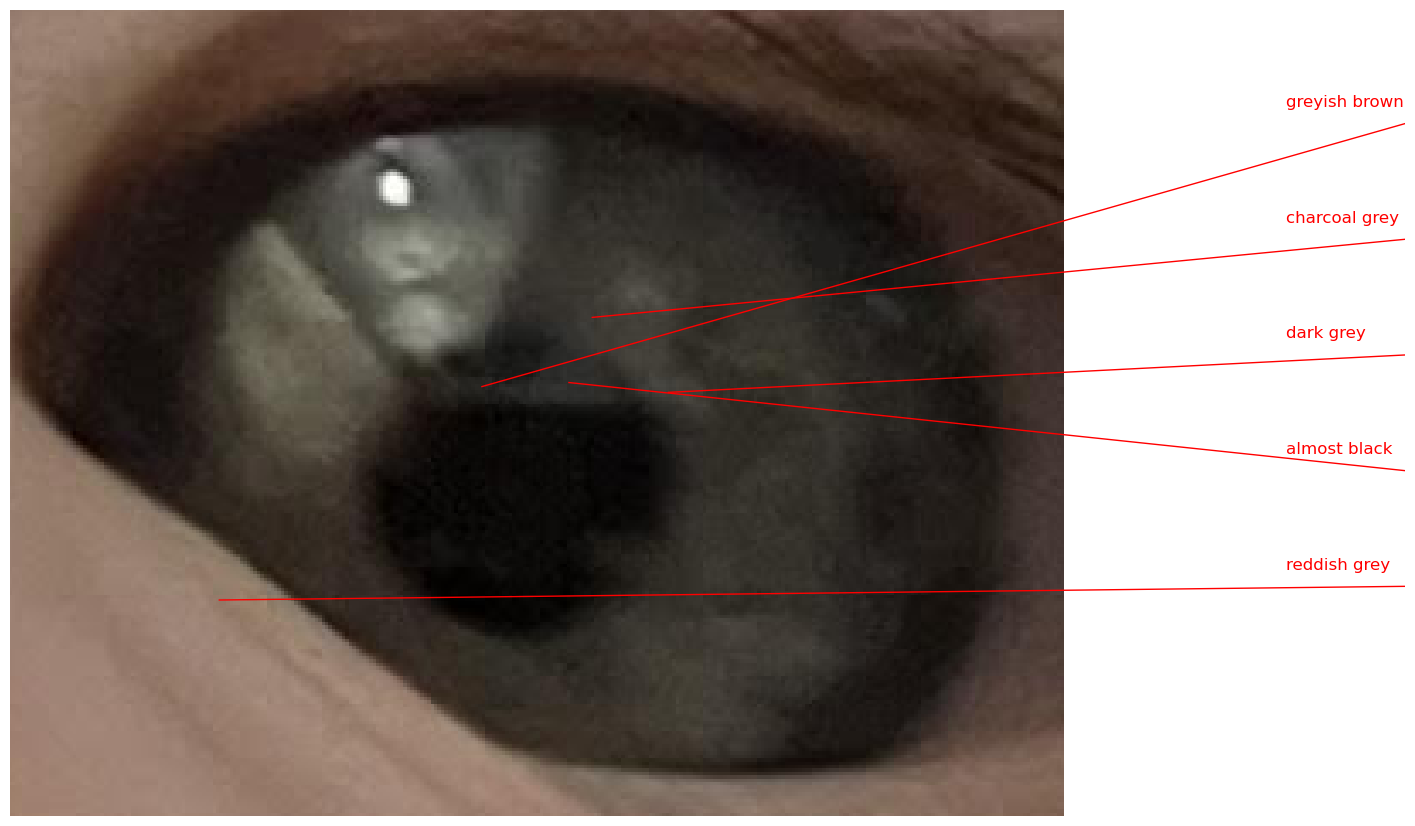

In [34]:

file_path = '../saves/png/baby_left_eye.png'
draw_top_colors_diagram(file_path, n_colors=5, verbose=False)

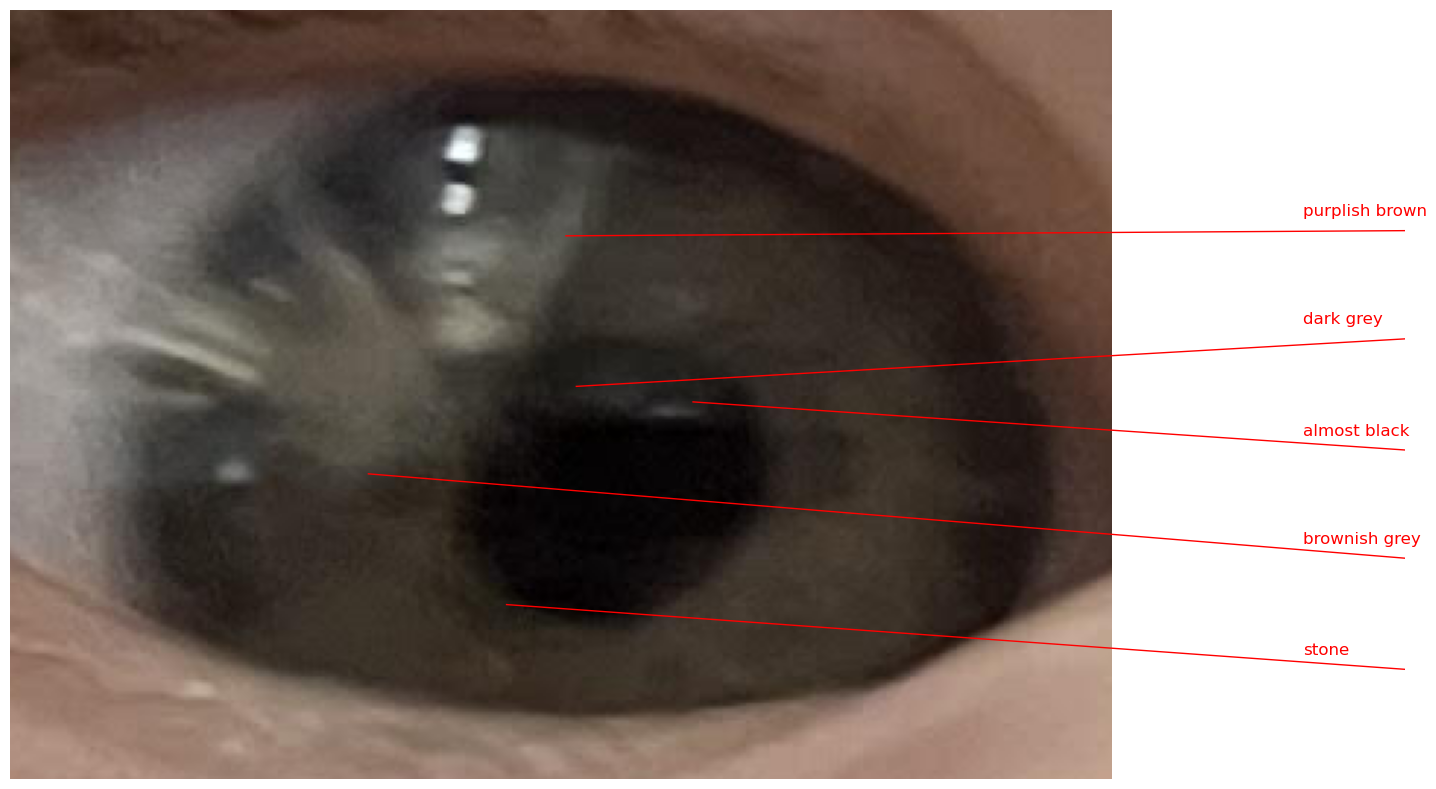

In [35]:

file_path = '../saves/png/baby_right_eye.png'
draw_top_colors_diagram(file_path, n_colors=5, verbose=False)

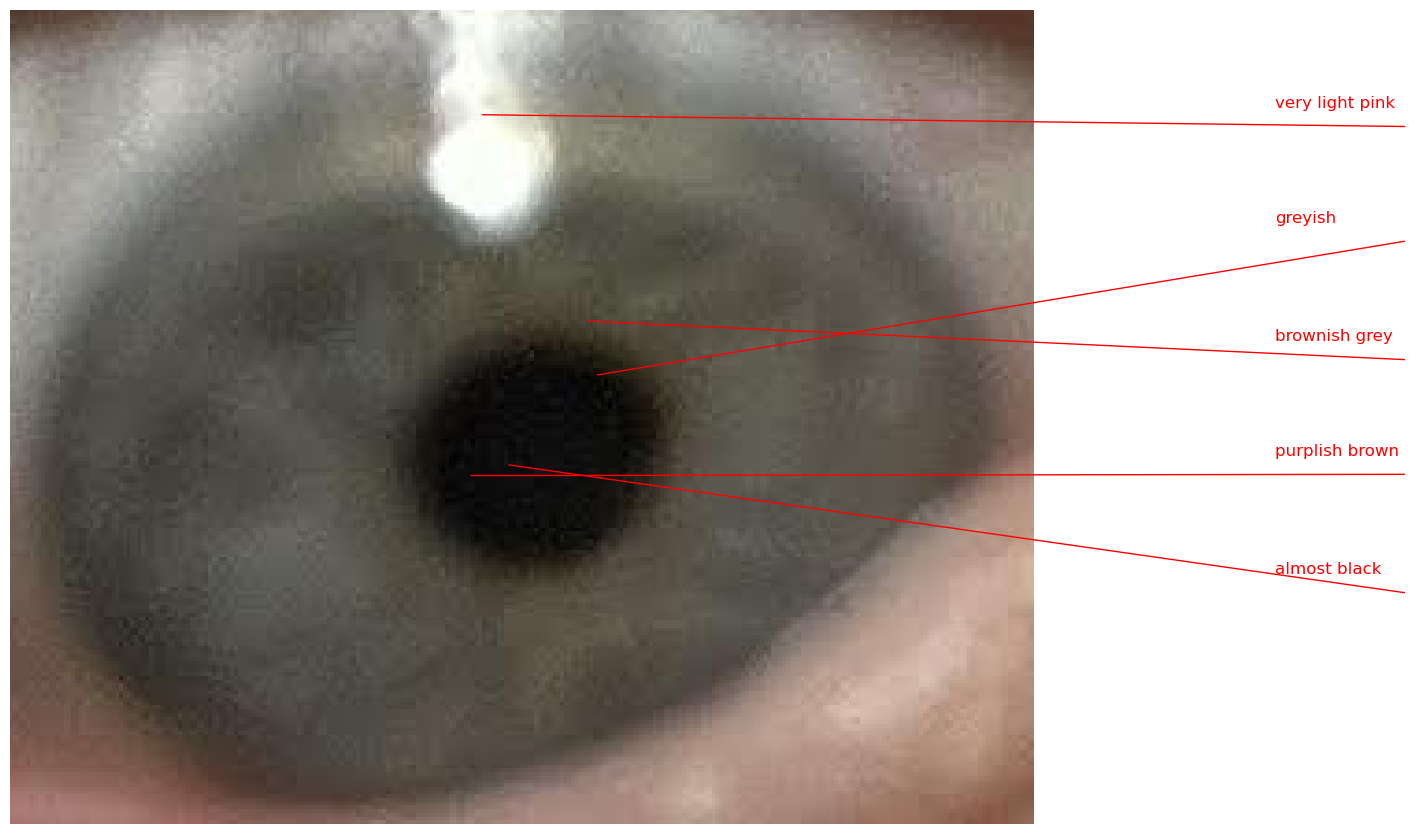

In [36]:

file_path = '../saves/png/dave_right_eye.png'
draw_top_colors_diagram(file_path, n_colors=5, verbose=False)

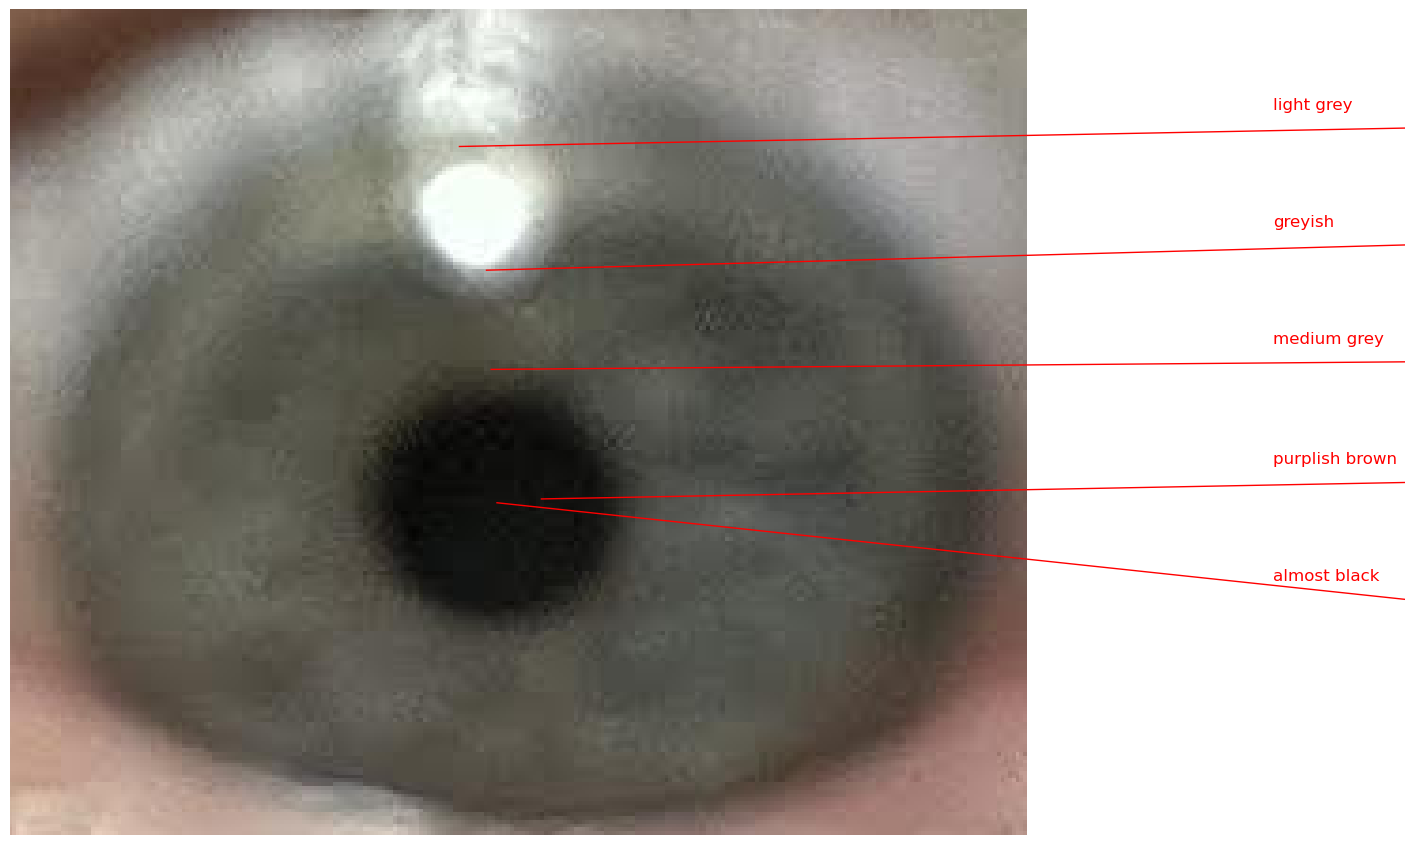

In [37]:

file_path = '../saves/png/dave_left_eye.png'
draw_top_colors_diagram(file_path, n_colors=5, verbose=False)

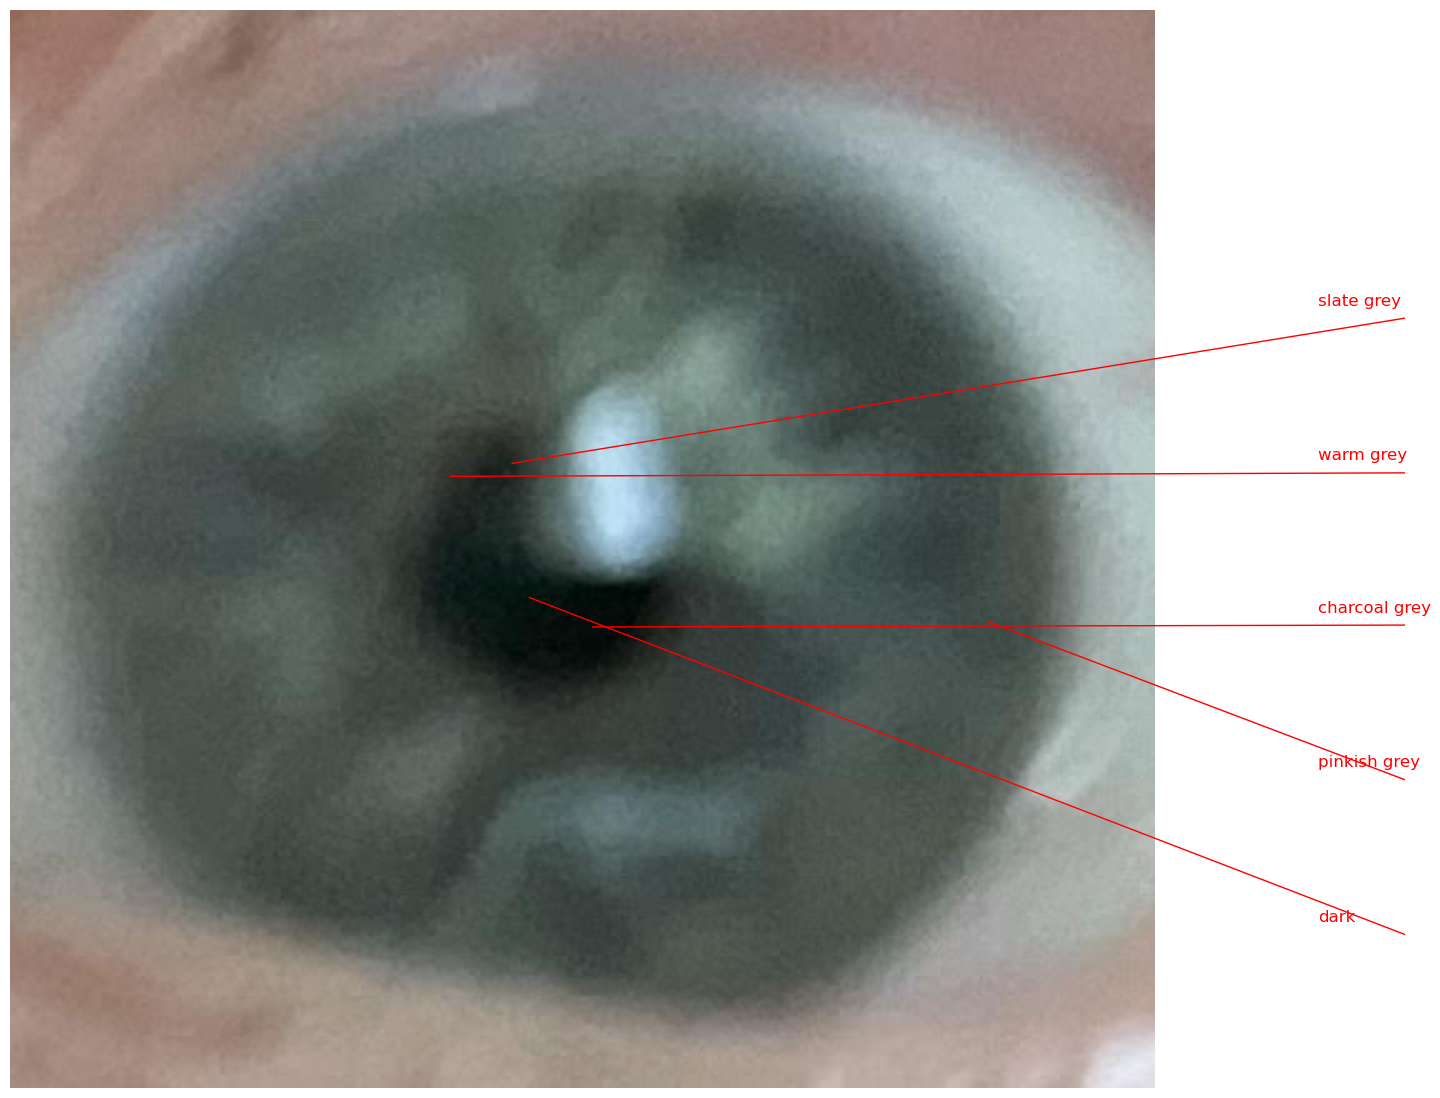

In [38]:

file_path = '../saves/png/mimi_left_eye.png'
draw_top_colors_diagram(file_path, n_colors=5, verbose=False)

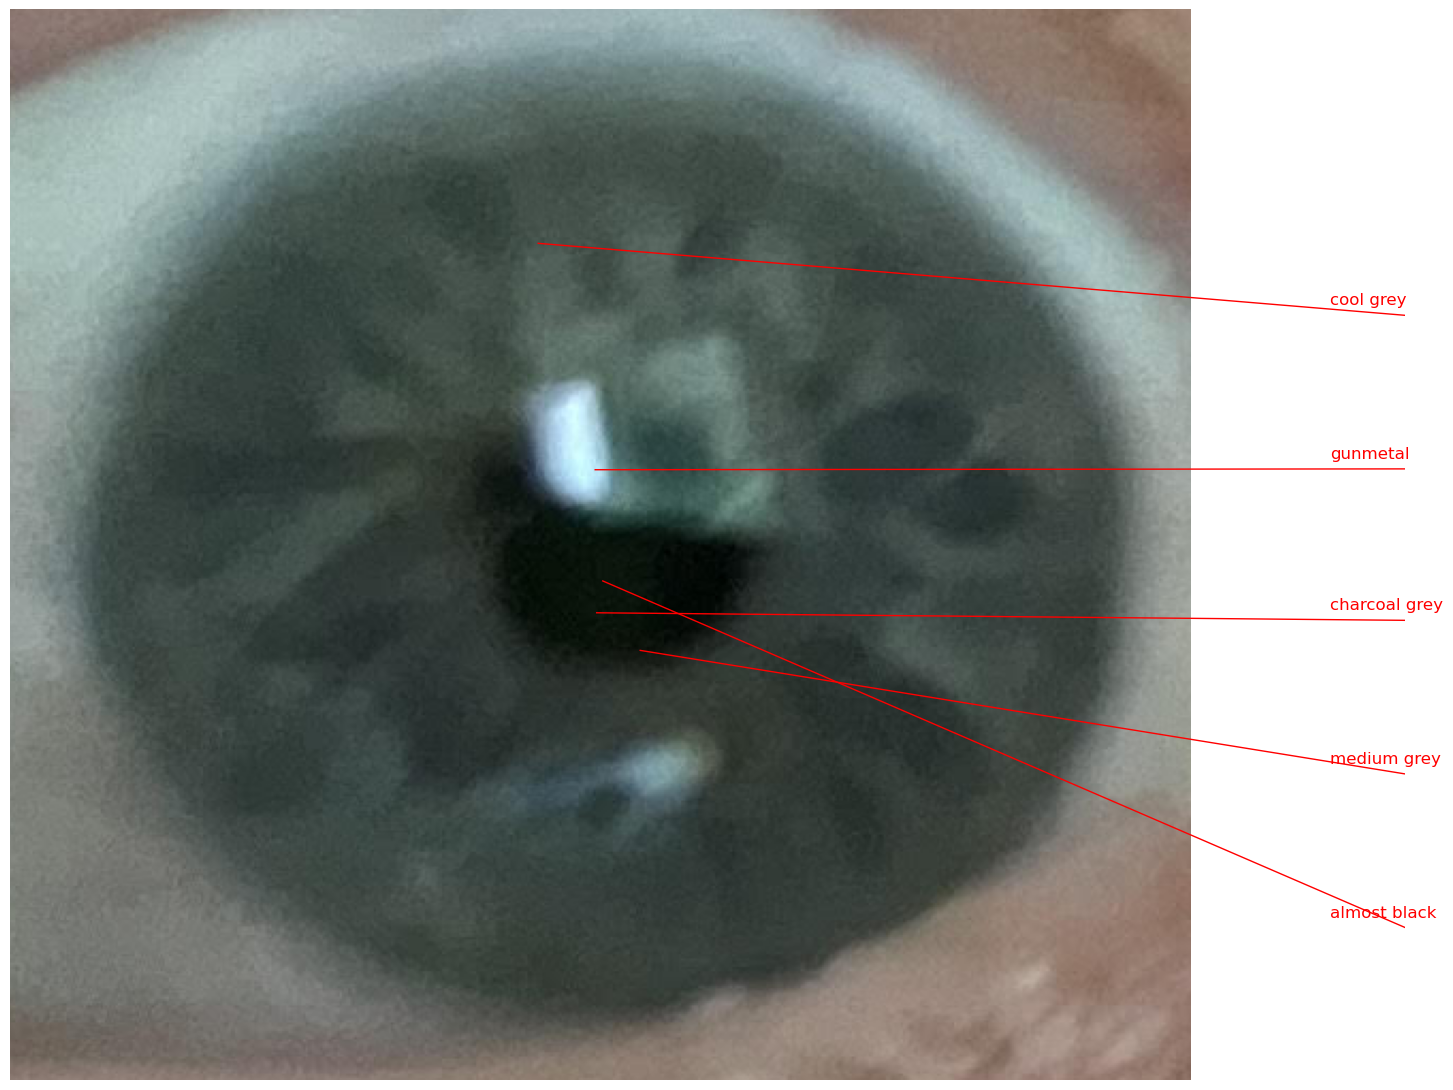

In [39]:

file_path = '../saves/png/mimi_right_eye.png'
draw_top_colors_diagram(file_path, n_colors=5, verbose=False)

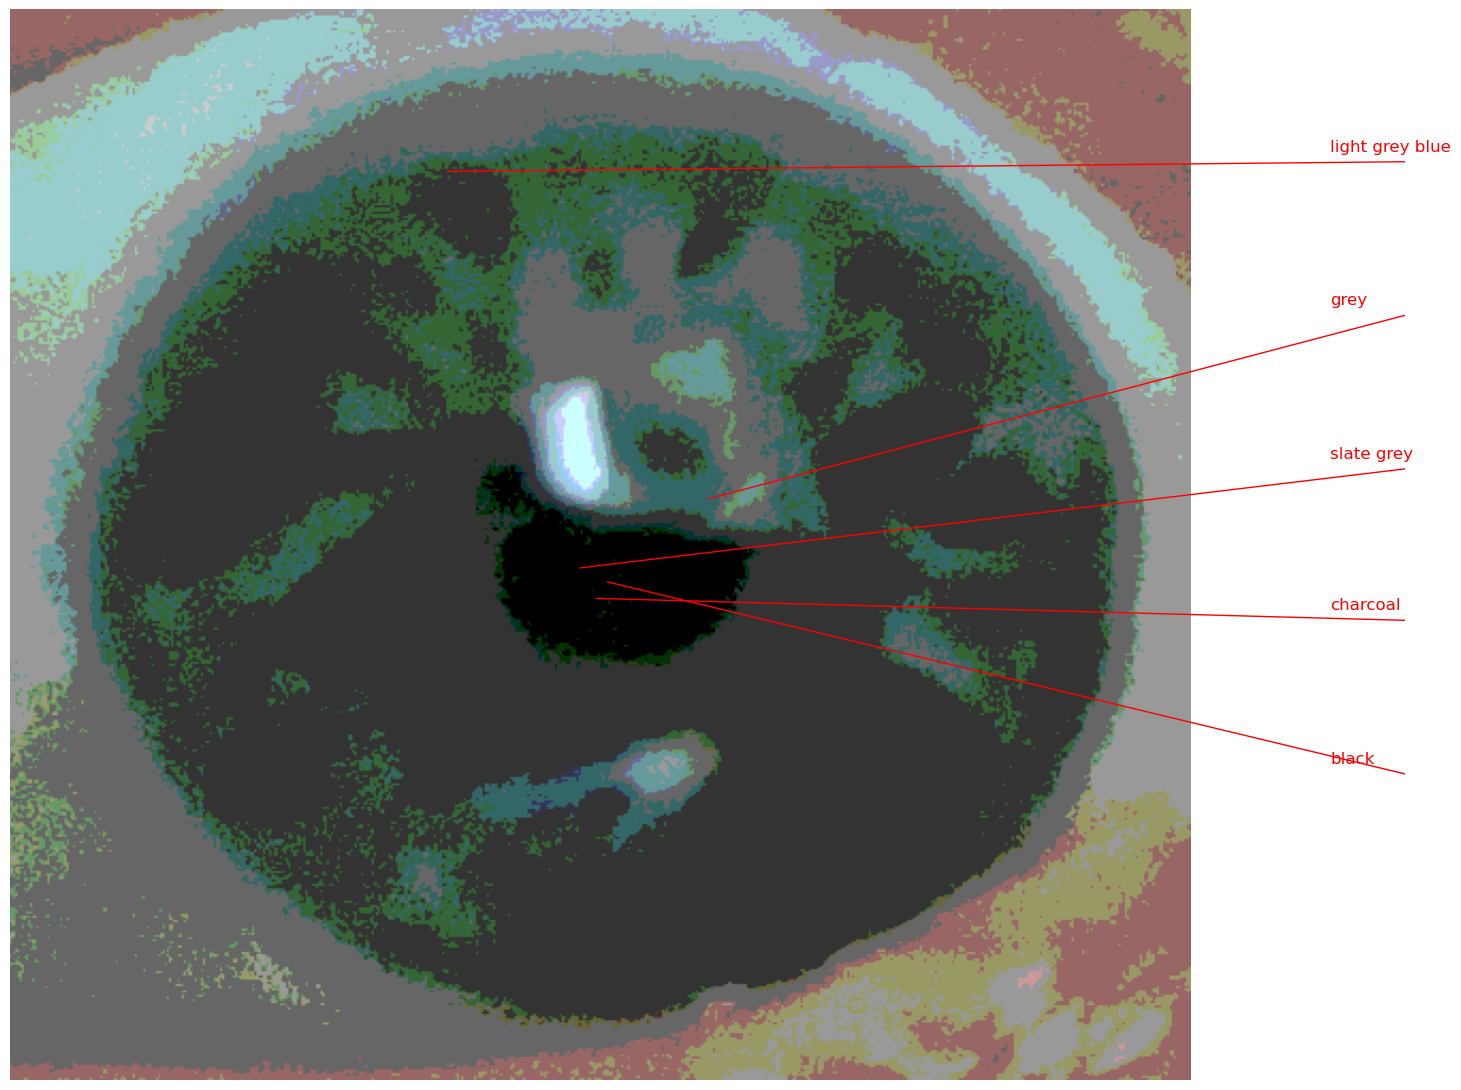

In [43]:

file_path = '../saves/png/mimi_right_eye_posterize_level6.png'
draw_top_colors_diagram(file_path, n_colors=5, verbose=False)

In [ ]:

def get_luminance(unicolor_patch):
    
    # Photometric/digital ITU BT.709 RGB -> Luma conversion formula
    red_value = int(unicolor_patch[0][0][0])
    green_value = int(unicolor_patch[0][0][1])
    blue_value = int(unicolor_patch[0][0][2])
    luminance = 0.2126*red_value + 0.7152*green_value + 0.0722*blue_value
    
    return luminance

In [42]:

def get_avg_patch(img_array):
    
    # Get the palette color which is the mean of each chromatic channel
    average = tuple(img_array.mean(axis=0).mean(axis=0))
    if verbose: print(f'average: {average}')
    
    # Create a palette with the mean
    avg_patch = np.ones(shape=img_array.shape, dtype=np.uint8)*np.uint8(average)

    return avg_patch

In [45]:

def get_dom_patch(palette, counts, img_array, verbose=False):
    
    # Get the palette color which occurs most frequently
    dominant = tuple(palette[np.argmax(counts)])
    if verbose: print(f'dominant: {dominant}')
    
    # Create a palette with the most frequent color
    dom_patch = np.ones(shape=img_array.shape, dtype=np.uint8)*np.uint8(dominant)
    
    return dom_patch

In [50]:

def get_weighted_avg_patch(palette_patch, img_array, verbose=False):
    
    # Get the palette color which is the weighted average of the representative colors
    weighted_average = tuple(palette_patch.mean(axis=0).mean(axis=0))
    if verbose: print(f'weighted_average: {weighted_average}')
    
    # Create a palette with the weighted average
    weighted_avg_patch = np.ones(shape=img_array.shape, dtype=np.uint8)*np.uint8(weighted_average)
    
    return weighted_avg_patch

error error trying to fitEllipse: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:355: error: (-215:Assertion failed) n >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::fitEllipseNoDirect'
error error trying to fitEllipse: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:355: error: (-215:Assertion failed) n >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::fitEllipseNoDirect'
error error trying to fitEllipse: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:355: error: (-215:Assertion failed) n >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::fitEllipseNoDirect'


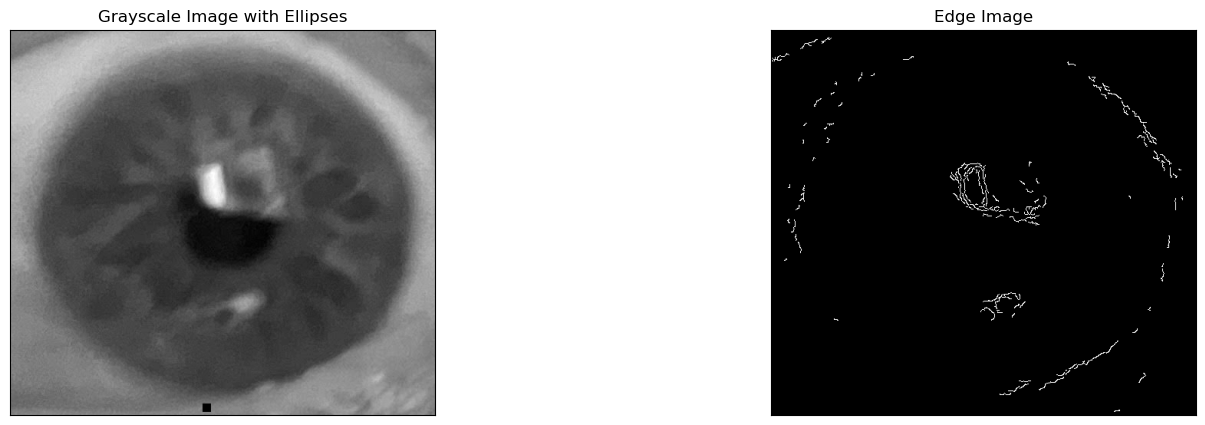

In [40]:

# See if you can get a ellipses around the iris
import cv2
import matplotlib.pyplot as plt

# Read the image
file_path = '../saves/png/mimi_right_eye.png'
gray_image = get_gray_image(file_path)

# Apply Canny edge detection
edges = get_edge_image(gray_image)

# Get the dimensions of the image
height, width = gray_image.shape[:2]

# Heuristic for potential iris center coordinates (adjusted based Circular Hough Transform to identify potential iris boundaries)
potential_centers = [(int(width/2), int(height/2))]

# Assume the iris occupies approximately 90% of the image width
estimated_iris_diameter_percentage = 0.9

# Calculate the estimated radius in pixels and use it as the minRadius in HoughCircles
estimated_iris_radius = int((width * estimated_iris_diameter_percentage) / 2)

# Circle detection
circles = cv2.HoughCircles(
    edges, cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=int(min(255, 1.3 * np.median(gray_image))), param2=8, minRadius=estimated_iris_radius, maxRadius=int(width/2)
)
if circles.any():
    
    # Convert the circle parameters (x, y, radius) to integers
    circles = np.round(circles[0, :]).astype("int")
    
    # Loop over the circles
    for (x, y, r) in circles:
        
        # Add the circle to the potential iris center coordinates
        center = (x, y)
        potential_centers.append(center)

# Define minimum confidence level for ellipse fit
min_confidence = 0.8

# Loop through potential iris centers
for center_x, center_y in potential_centers:
    
    # Draw a rectangle to indicate the center of the circle
    cv2.rectangle(gray_image, pt1=(x - 5, y - 5), pt2=(x + 5, y + 5), color=(0, 128, 255), thickness=-1)
    
    # Extract a patch around the center
    patch_start_x = max(0, center_x - estimated_iris_radius)
    patch_start_y = max(0, center_y - estimated_iris_radius)
    patch_end_x = min(width, center_x + estimated_iris_radius)
    patch_end_y = min(height, center_y + estimated_iris_radius)
    
    # Check if patch is not empty (optional)
    if patch_start_x != patch_end_x and patch_start_y != patch_end_y:
        patch = gray_image[patch_start_y:patch_end_y, patch_start_x:patch_end_x]
        
        # Fit an ellipse to the patch
        try:
            ellipse_params = cv2.fitEllipse(patch)
            
            # Check confidence level (higher is better)
            confidence = ellipse_params[-1]
            if confidence > min_confidence:
                
                # Extract ellipse parameters
                center = (ellipse_params[0] + patch_start_x, ellipse_params[1] + patch_start_y)
                width = ellipse_params[2]
                height = ellipse_params[3]
                angle = ellipse_params[4]
                
                # Draw the ellipse on the original image
                cv2.ellipse(gray_image, center, (int(width/2), int(height/2)), angle, 0, 360, (0, 255, 0), 2)
        
        except Exception as e: print(f'{e.__class__.__name__} error trying to fitEllipse: {str(e).strip()}')

# Display the original image and the edge-detected image with ellipses
plt.figure(figsize=(18, 5))

plt.subplot(121), plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image with Ellipses'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

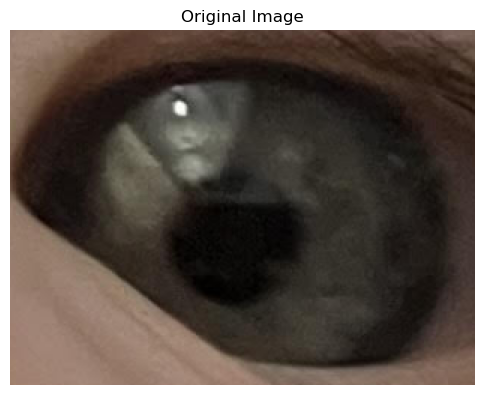

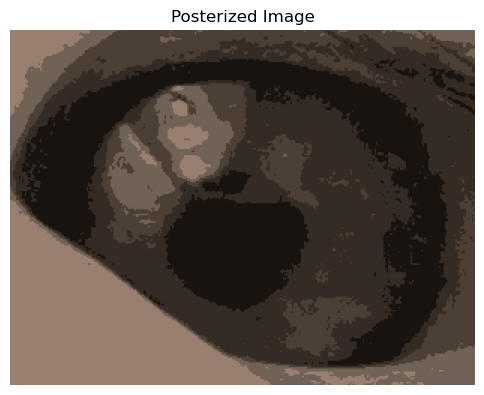

Top 5 colors used in the posterized image:
[51 43 36]
[112  98  85]
[76 63 53]
[153 127 112]
[25 19 16]


In [71]:

# Define the image path (replace with your actual path if needed)
file_path = '../saves/png/baby_left_eye.png'

# Read the image
# img_array = cv2.imread(file_path)
rgb_array = get_original_image(file_path)
# rgb_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

# Replace pixel values with their corresponding palette colors
posterized_img = get_posterized_image(rgb_array, n_colors=5, verbose=False)

# Display the original image
plt.figure(figsize=(6, 6))  # Adjust figure size as desired
plt.imshow(rgb_array)
plt.title("Original Image")
plt.axis('off')  # Hide axes for cleaner display
plt.show()

# Display the posterized image
plt.figure(figsize=(6, 6))  # Adjust figure size as desired
plt.imshow(posterized_img.astype(np.uint8))
plt.title("Posterized Image")
plt.axis('off')  # Hide axes for cleaner display
plt.show()

print("Top 5 colors used in the posterized image:")
# Print the top 5 colors from the palette (rounded for display)
for color in palette.astype(np.uint8):
  print(f"{color}")  # This will print the top 5 colors used in the posterized image

In [35]:

potential_centers

[(277, 251), (252, 220), (256, 492)]

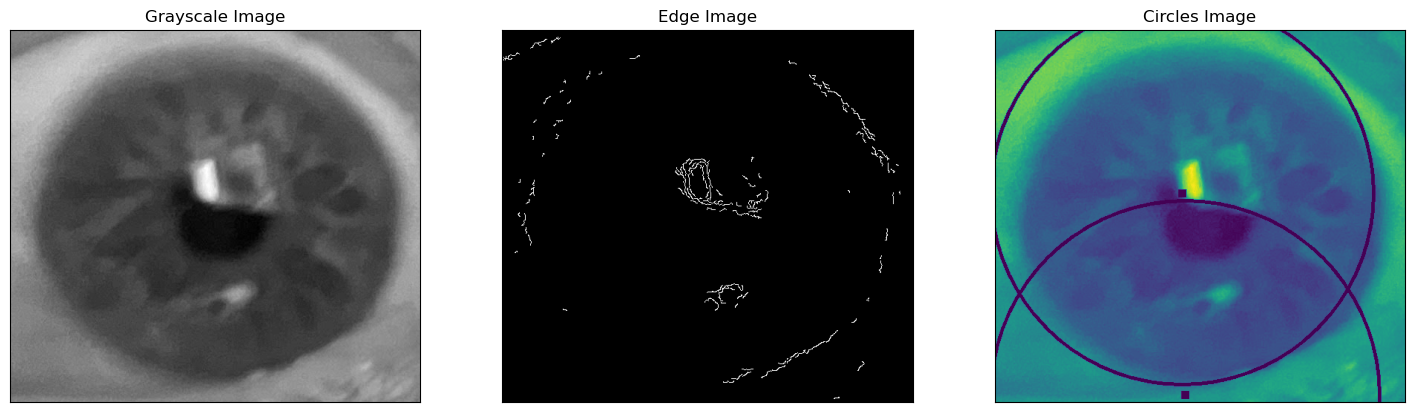

In [38]:

# See if you can get a circle around the iris
import cv2
import matplotlib.pyplot as plt

# Read the image
file_path = '../saves/png/mimi_right_eye.png'
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Calculate the median of the pixel intensities
median_val = np.median(img)

# Set the lower and upper thresholds based on the median
lower = int(max(0, 0.7 * median_val))
upper = int(min(255, 1.3 * median_val))

# Apply Canny edge detection
edges = cv2.Canny(image=img, threshold1=lower, threshold2=upper)

# Get the dimensions of the image
height, width = gray_image.shape[:2]

# Assume the iris occupies approximately 90% of the image width
estimated_iris_diameter_percentage = 0.9

# Calculate the estimated radius in pixels
estimated_iris_radius = int((width * estimated_iris_diameter_percentage) / 2)

# Use the estimated radius as the minRadius in HoughCircles
minRadius = estimated_iris_radius

# Circle detection
circles = cv2.HoughCircles(
    edges, cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=upper, param2=8, minRadius=minRadius, maxRadius=int(width/2)
)
if circles.any():
    
    # Display the original image and the edge-detected image
    plt.figure(figsize=(18, 5))
    plt.subplot(131), plt.imshow(img, cmap='gray')
    plt.title('Grayscale Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(edges, cmap='gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    
    # Convert the circle parameters (x, y, radius) to integers
    circles = np.round(circles[0, :]).astype("int")
    
    # Loop over the circles
    for (x, y, r) in circles:
        
        # Draw the circle in the output image
        cv2.circle(img, (x, y), r, (0, 255, 0), 4)
        
        # Draw a rectangle to indicate the center of the circle
        cv2.rectangle(img, pt1=(x - 5, y - 5), pt2=(x + 5, y + 5), color=(0, 128, 255), thickness=-1)
    
    plt.subplot(133), plt.imshow(img)
    plt.title('Circles Image'), plt.xticks([]), plt.yticks([])
    plt.show()

In [36]:

cv2.rectangle?

Docstring:
rectangle(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) -> img
.   @brief Draws a simple, thick, or filled up-right rectangle.
.   
.   The function cv::rectangle draws a rectangle outline or a filled rectangle whose two opposite corners
.   are pt1 and pt2.
.   
.   @param img Image.
.   @param pt1 Vertex of the rectangle.
.   @param pt2 Vertex of the rectangle opposite to pt1 .
.   @param color Rectangle color or brightness (grayscale image).
.   @param thickness Thickness of lines that make up the rectangle. Negative values, like #FILLED,
.   mean that the function has to draw a filled rectangle.
.   @param lineType Type of the line. See #LineTypes
.   @param shift Number of fractional bits in the point coordinates.



rectangle(img, rec, color[, thickness[, lineType[, shift]]]) -> img
.   @overload
.   
.   use `rec` parameter as alternative specification of the drawn rectangle: `r.tl() and
.   r.br()-Point(1,1)` are opposite corners
Type:      builtin_function

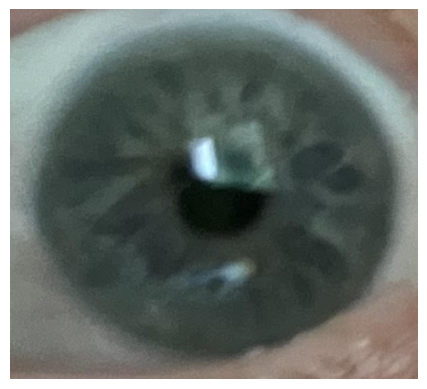

In [39]:

# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
file_path = '../saves/png/mimi_right_eye.png'
image = cv2.imread(file_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(gray_image, (7, 7), 0)

# Calculate the median of the pixel intensities
median_val = np.median(blurred_image)

# Set the lower and upper thresholds based on the median
lower = int(max(0, 0.7 * median_val))
upper = int(min(255, 1.3 * median_val))

# Apply Canny edge detection
edges = cv2.Canny(image=blurred_image, threshold1=lower, threshold2=upper)

# Get the dimensions of the image
height, width = gray_image.shape[:2]

# Assume the iris occupies approximately 90% of the image width
estimated_iris_diameter_percentage = 0.9

# Calculate the estimated radius in pixels
estimated_iris_radius = int((width * estimated_iris_diameter_percentage) / 2)

# Use the estimated radius as the minRadius in HoughCircles
minRadius = estimated_iris_radius

# Circle detection
circles = cv2.HoughCircles(
    edges, cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=upper, param2=8, minRadius=minRadius, maxRadius=int(width/2)
)

# Ensure at least some circles were found
if circles is not None:
    
    # Convert the circle parameters (x, y, radius) to integers
    circles = np.round(circles[0, :]).astype("int")

    # Loop over the circles
    for (x, y, r) in circles:
        
        # Draw the circle in the output image
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        
        # Draw a rectangle to indicate the center of the circle
        cv2.rectangle(image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

# Convert BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()


# What Color is your Hair?

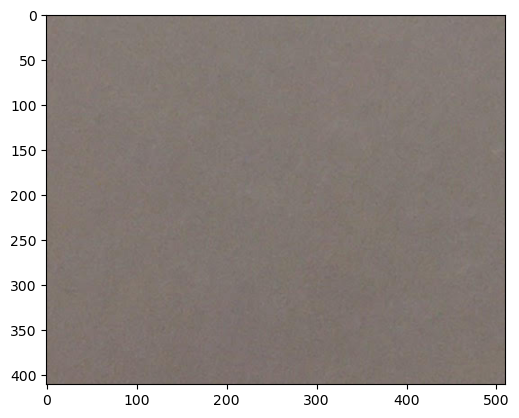

In [4]:

# Read the image
file_path = '../saves/png/Latest_Screenshot.png'
# file_path = '.../saves/png/photo_of_hair.png'
def get_rgb_img(file_path):
    imread_img = cv2.imread(file_path)
    
    # Convert to RGB (necessary for xkcd search)
    img_rgb = cv2.cvtColor(imread_img, cv2.COLOR_BGR2RGB)

    return img_rgb
img_rgb = get_rgb_img(file_path)
plt.imshow(img_rgb);

In [5]:

def show_sample(rgb_tuple):
    
    # Extract only the first 3 channels (RGB)
    rgb_tuple = rgb_tuple[:3]
    
    # Create the 10x10 square with the truncated RGB color
    square = np.full((10, 10, 3), rgb_tuple, dtype=np.uint8)
    
    plt.imshow(square);

Average RGB in area: (128.98514860932207, 118.84799866418587, 113.50370211344878, 0.0)


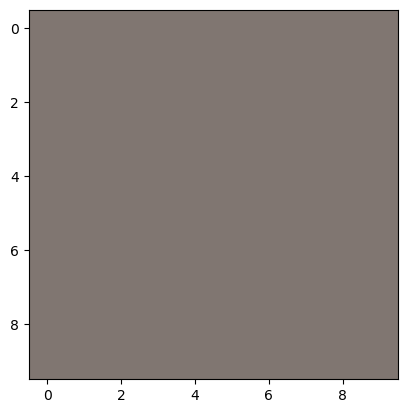

In [6]:

# Calculate the average RGB value within the area
avg_rgb = cv2.mean(img_rgb)

# Print the average RGB values
print(f'Average RGB in area: {avg_rgb}')
show_sample(avg_rgb)

In [9]:

import numpy as np

def get_unique_rgb_values(rbg_img):
    
    # Flatten the RGB image into a 1D array of pixels
    pixels = rbg_img.reshape((-1, 3))  # Reshape into (num_pixels, 3)
    unique_rgb_values = set(tuple(px) for px in pixels)

    return unique_rgb_values
def get_pixels_sorted_by_brightness(pixels):
    
    # Sort the pixels by brightness (sum of RGB values) in ascending order
    sorted_pixels = pixels[np.argsort(pixels.sum(axis=1))]

    return sorted_pixels

# Extract the darkest and lightest pixel (first and last in the sorted array)
unique_rgb_values = get_unique_rgb_values(img_rgb)
sorted_pixels = get_pixels_sorted_by_brightness(np.array(list(unique_rgb_values)))
darkest_rgb = [px for px in sorted_pixels if not np.all(px == [0, 0, 0])][0]
lightest_rgb = [px for px in sorted_pixels if not np.all(px == [255, 255, 255])][-1]

Darkest RGB value: [114 106  95]


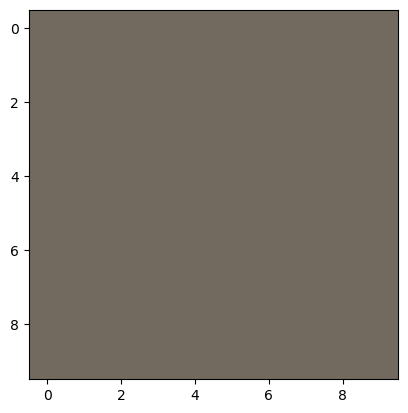

In [10]:

# Print the darkest RGB value
print(f'Darkest RGB value: {darkest_rgb}')
show_sample(darkest_rgb)

Lightest RGB value: [142 133 128]


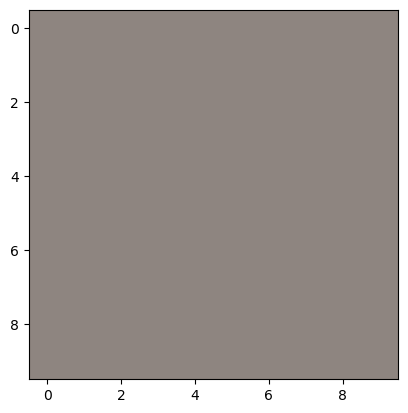

In [11]:

# Print the lightest RGB value
print(f'Lightest RGB value: {lightest_rgb}')
show_sample(lightest_rgb)

In [14]:

colors_list = list(set([get_nearest_xkcd_color(px) for px in unique_rgb_values]))
conjunction_str = nu.conjunctify_nouns([f'"{n}"' for n in colors_list])
print(f'Describe this hair using these terms: {conjunction_str}.')

Describe this hair using these terms: "grey brown", "reddish grey", "brownish grey", "purple grey", "purplish grey", "medium grey", "greyish brown", "brown grey", and "warm grey".


In [18]:

for color in colors_list: print(f"show_sample(xkcd_colors['{color}'])")

show_sample(xkcd_colors['grey brown'])
show_sample(xkcd_colors['reddish grey'])
show_sample(xkcd_colors['brownish grey'])
show_sample(xkcd_colors['purple grey'])
show_sample(xkcd_colors['purplish grey'])
show_sample(xkcd_colors['medium grey'])
show_sample(xkcd_colors['greyish brown'])
show_sample(xkcd_colors['brown grey'])
show_sample(xkcd_colors['warm grey'])


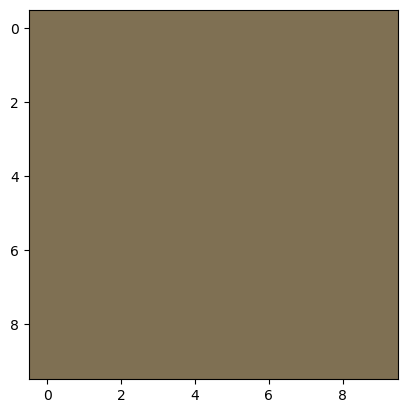

In [19]:

show_sample(xkcd_colors['grey brown'])

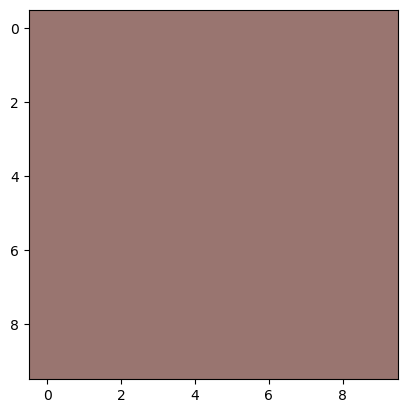

In [20]:

show_sample(xkcd_colors['reddish grey'])

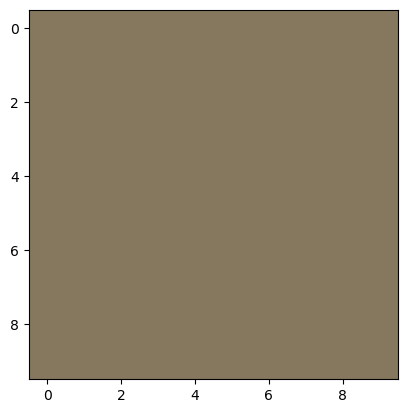

In [21]:

show_sample(xkcd_colors['brownish grey'])

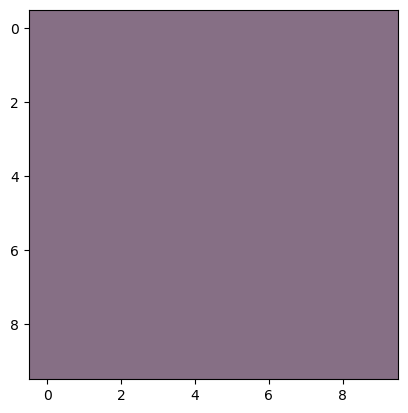

In [22]:

show_sample(xkcd_colors['purple grey'])

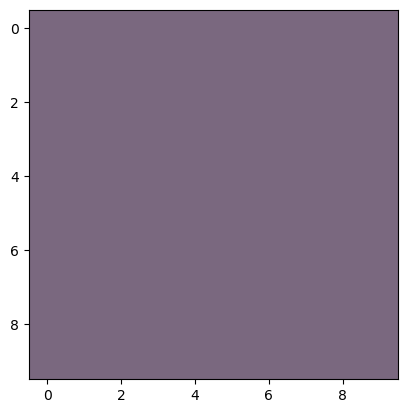

In [23]:

show_sample(xkcd_colors['purplish grey'])

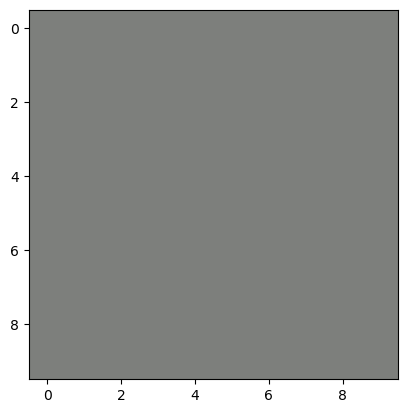

In [24]:

show_sample(xkcd_colors['medium grey'])

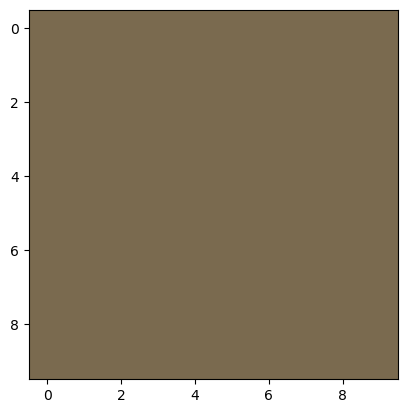

In [25]:

show_sample(xkcd_colors['greyish brown'])

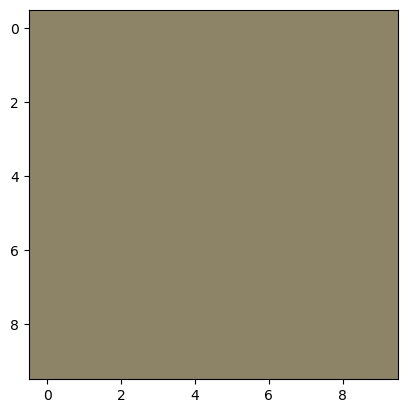

In [26]:

show_sample(xkcd_colors['brown grey'])

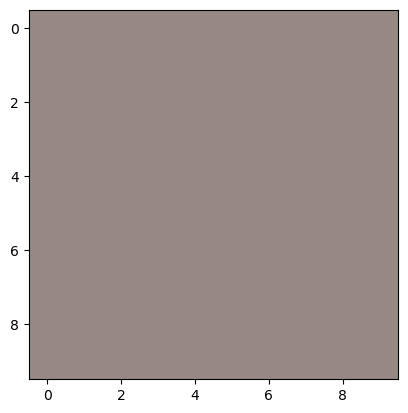

In [27]:

show_sample(xkcd_colors['warm grey'])


----

In [ ]:

def get_center_25_percent(img_rgb):
    
    # Calculate the width and height of the image
    img_width, img_height = img_rgb.shape[1], img_rgb.shape[0]
    
    # Calculate the center coordinates and half-width/height of the 25% area
    center_x = img_width // 2
    center_y = img_height // 2
    half_width = int(img_width * 0.25) // 2
    half_height = int(img_height * 0.25) // 2
    
    # Extract the center 25% area
    center_area = img_rgb[center_y - half_height : center_y + half_height, center_x - half_width : center_x + half_width]

    return center_area
center_area = get_center_25_percent(img_rgb)
plt.imshow(center_area);

In [ ]:

# Read the image again
imread_img = cv2.imread(file_path)

# Preprocessing steps
# Convert to grayscale for easier processing
gray = cv2.cvtColor(imread_img, cv2.COLOR_BGR2GRAY)

# Blur the image to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply edge detection to find hair boundaries
edges = cv2.Canny(blurred, 50, 150)

# Perform morphological closing to fill in hair gaps
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find the largest connected component, assuming it's the hair
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Calculate the area of the hair (largest contour)
hair_area = cv2.contourArea(largest_contour)

# Print the area of the hair
print(f'Area of the hair: {hair_area} pixels')

# Optionally, draw the contour on the image and display it
# cv2.drawContours(imread_img, [largest_contour], -1, (0, 255, 0), 2)
# cv2.imshow('Image with hair contour', imread_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:

# Create a mask from the largest contour
mask = np.zeros(img_rgb.shape[:2], np.uint8)
cv2.drawContours(mask, [largest_contour], -1, 255, -1)

# Calculate the average RGB value within the mask
avg_rgb = cv2.mean(img_rgb, mask=mask)

# Print the average RGB values
print(f'Average RGB: {avg_rgb}')

In [ ]:

cv2.drawContours(imread_img, [largest_contour], -1, (0, 255, 0), 2)
plt.imshow(imread_img);

In [6]:

# Define the URL and filename
url = 'https://xkcd.com/color/rgb.txt'
file_path = osp.join(nu.saves_text_folder, 'xkcd_colors.txt')

# Send the request and check for success
response = requests.get(url)

# Write the content to the file
if response.status_code == 200:
    with open(file_path, 'wb') as f: f.write(response.content)
    print(f'Downloaded xkcd color list to {file_path}')
else: print(f'Error downloading file: {response.status_code}')

Downloaded xkcd color list to C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\txt\xkcd_colors.txt


In [33]:

[f'webcolors.{fn}' for fn in dir(webcolors)]

['webcolors.CSS2', 'webcolors.CSS21', 'webcolors.CSS21_HEX_TO_NAMES', 'webcolors.CSS21_NAMES_TO_HEX', 'webcolors.CSS2_HEX_TO_NAMES', 'webcolors.CSS2_NAMES_TO_HEX', 'webcolors.CSS3', 'webcolors.CSS3_HEX_TO_NAMES', 'webcolors.CSS3_NAMES_TO_HEX', 'webcolors.HTML4', 'webcolors.HTML4_HEX_TO_NAMES', 'webcolors.HTML4_NAMES_TO_HEX', 'webcolors.HTML5SimpleColor', 'webcolors.IntTuple', 'webcolors.IntegerRGB', 'webcolors.PercentRGB', 'webcolors.PercentTuple', 'webcolors.__all__', 'webcolors.__builtins__', 'webcolors.__cached__', 'webcolors.__doc__', 'webcolors.__file__', 'webcolors.__loader__', 'webcolors.__name__', 'webcolors.__package__', 'webcolors.__path__', 'webcolors.__spec__', 'webcolors.__version__', 'webcolors.constants', 'webcolors.conversion', 'webcolors.hex_to_name', 'webcolors.hex_to_rgb', 'webcolors.hex_to_rgb_percent', 'webcolors.html5', 'webcolors.html5_parse_legacy_color', 'webcolors.html5_parse_simple_color', 'webcolors.html5_serialize_simple_color', 'webcolors.name_to_hex', 'we

In [34]:

webcolors.rgb_to_name?

Signature:
webcolors.rgb_to_name(
    rgb_triplet: Union[webcolors.types.IntegerRGB, webcolors.types.HTML5SimpleColor, Tuple[int, int, int]],
    spec: str = 'css3',
) -> str
Docstring:
Convert a 3-:class:`tuple` of :class:`int`, suitable for use in an ``rgb()``
color triplet, to its corresponding normalized color name, if any
such name exists.

To determine the name, the triplet will be converted to a
normalized hexadecimal value.

.. note:: **Spelling variants**

   Some values representing named gray colors can map to either of two names in
   CSS3, because it supports both ``"gray"`` and ``"grey"`` spelling variants for
   those colors. This function will always return the variant spelled ``"gray"``
   (such as ``"lightgray"`` instead of ``"lightgrey"``). See :ref:`the documentation
   on name conventions <color-name-conventions>` for details.

Examples:

.. doctest::

    >>> rgb_to_name((255, 255, 255))
    'white'
    >>> rgb_to_name((0, 0, 128))
    'navy'

:param rgb_triplet: 